# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


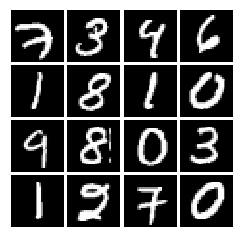

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    relu_out = tf.maximum(x,alpha*x)
    return relu_out


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    noise = tf.random_uniform([batch_size,dim],-1,1)
    return noise


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        layer1 = tf.layers.dense(x,256,leaky_relu)
        layer2 = tf.layers.dense(layer1,256,leaky_relu)
        logits = tf.layers.dense(layer2,1)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        layer1 = tf.layers.dense(z,1024,tf.nn.relu)
        layer2 = tf.layers.dense(layer1,1024,tf.nn.relu)
        img = tf.layers.dense(layer2,784,tf.tanh)
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [17]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= tf.ones_like(logits_fake),logits=logits_fake))
    D_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels= tf.ones_like(logits_fake),logits=logits_real)
    D_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake),logits=logits_fake)
    D_loss = tf.reduce_mean(D_real_loss + D_fake_loss)
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [18]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [19]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver = tf.train.AdamOptimizer(learning_rate,beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate,beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [20]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [21]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

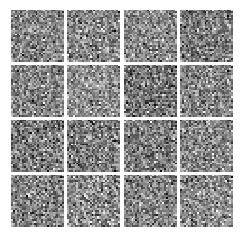


Iter: 0, D: 1.431, G:0.7247
Iter: 50, D: 1.867, G:1.797
Iter: 100, D: 2.8, G:0.9533
Iter: 150, D: 1.061, G:1.778
Iter: 200, D: 1.538, G:0.8323


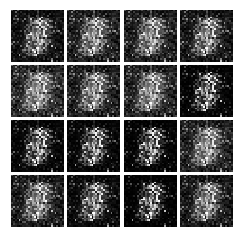


Iter: 250, D: 0.8471, G:1.908
Iter: 300, D: 1.162, G:1.441
Iter: 350, D: 0.9991, G:2.562
Iter: 400, D: 1.193, G:0.9193
Iter: 450, D: 1.066, G:1.383


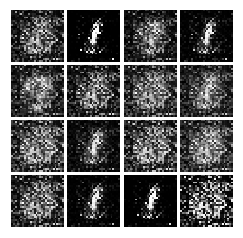


Iter: 500, D: 0.9574, G:1.324
Iter: 550, D: 1.034, G:1.245
Iter: 600, D: 1.236, G:1.273
Iter: 650, D: 1.069, G:1.323
Iter: 700, D: 1.125, G:1.56


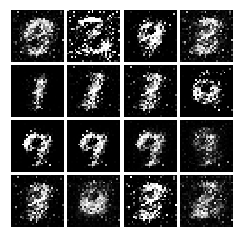


Iter: 750, D: 1.086, G:1.142
Iter: 800, D: 1.076, G:1.074
Iter: 850, D: 1.329, G:1.074
Iter: 900, D: 1.096, G:0.9797
Iter: 950, D: 1.335, G:0.9345


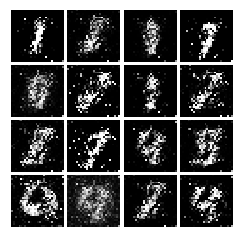


Iter: 1000, D: 1.221, G:1.1
Iter: 1050, D: 1.266, G:1.221
Iter: 1100, D: 1.099, G:1.658
Iter: 1150, D: 1.243, G:0.9338
Iter: 1200, D: 1.261, G:1.058


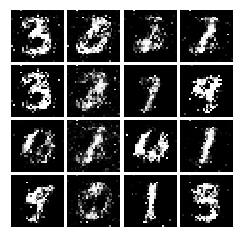


Iter: 1250, D: 1.272, G:0.8566
Iter: 1300, D: 1.132, G:1.458
Iter: 1350, D: 1.161, G:1.184
Iter: 1400, D: 1.224, G:1.086
Iter: 1450, D: 1.276, G:0.8257


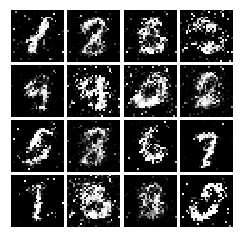


Iter: 1500, D: 1.338, G:0.9325
Iter: 1550, D: 1.221, G:0.933
Iter: 1600, D: 1.322, G:1.144
Iter: 1650, D: 1.3, G:0.8283
Iter: 1700, D: 1.361, G:0.7743


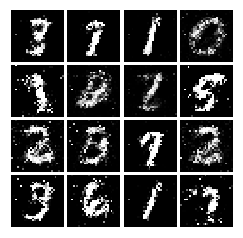


Iter: 1750, D: 1.277, G:0.9219
Iter: 1800, D: 1.234, G:0.9601
Iter: 1850, D: 1.246, G:0.9568
Iter: 1900, D: 1.351, G:0.8564
Iter: 1950, D: 1.308, G:0.9337


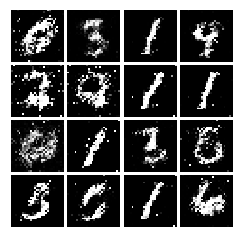


Iter: 2000, D: 1.256, G:0.9562
Iter: 2050, D: 1.239, G:1.025
Iter: 2100, D: 1.277, G:1.057
Iter: 2150, D: 1.281, G:0.8446
Iter: 2200, D: 1.354, G:0.8696


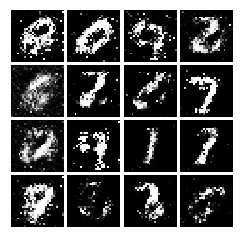


Iter: 2250, D: 1.285, G:0.8626
Iter: 2300, D: 1.331, G:0.8818
Iter: 2350, D: 1.3, G:0.8272
Iter: 2400, D: 1.274, G:0.9357
Iter: 2450, D: 1.26, G:0.8532


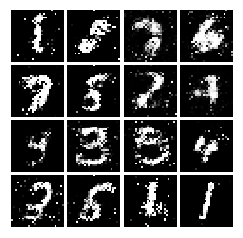


Iter: 2500, D: 1.29, G:0.9066
Iter: 2550, D: 1.308, G:0.9351
Iter: 2600, D: 1.3, G:0.8102
Iter: 2650, D: 1.288, G:0.8874
Iter: 2700, D: 1.293, G:0.8614


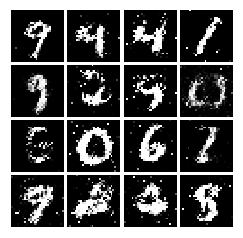


Iter: 2750, D: 1.289, G:0.8792
Iter: 2800, D: 1.272, G:0.7957
Iter: 2850, D: 1.307, G:0.8385
Iter: 2900, D: 1.335, G:0.859
Iter: 2950, D: 1.199, G:1.04


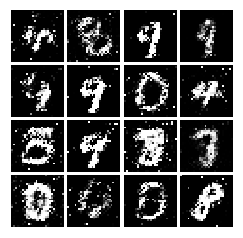


Iter: 3000, D: 1.301, G:0.886
Iter: 3050, D: 1.274, G:0.8371
Iter: 3100, D: 1.309, G:0.9033
Iter: 3150, D: 1.292, G:0.8021
Iter: 3200, D: 1.284, G:0.8249


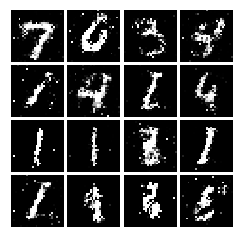


Iter: 3250, D: 1.335, G:0.8079
Iter: 3300, D: 1.258, G:0.8356
Iter: 3350, D: 1.368, G:0.8459
Iter: 3400, D: 1.27, G:0.849
Iter: 3450, D: 1.277, G:0.7964


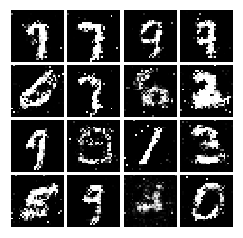


Iter: 3500, D: 1.288, G:0.9647
Iter: 3550, D: 1.335, G:0.8339
Iter: 3600, D: 1.308, G:0.8049
Iter: 3650, D: 1.346, G:0.825
Iter: 3700, D: 1.347, G:0.76


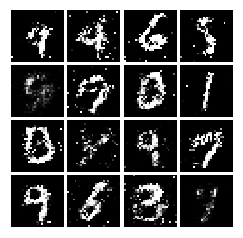


Iter: 3750, D: 1.328, G:0.8106
Iter: 3800, D: 1.358, G:0.7694
Iter: 3850, D: 1.294, G:0.8628
Iter: 3900, D: 1.286, G:0.7913
Iter: 3950, D: 1.337, G:0.8757


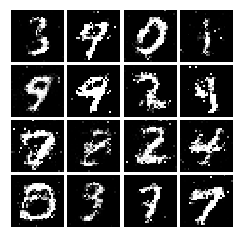


Iter: 4000, D: 1.331, G:0.8515
Iter: 4050, D: 1.425, G:0.8668
Iter: 4100, D: 1.319, G:0.8182
Iter: 4150, D: 1.311, G:0.7533
Iter: 4200, D: 1.316, G:0.7952


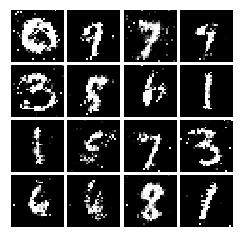


Iter: 4250, D: 1.325, G:0.85
Final images


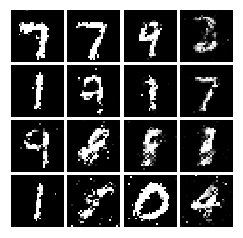

In [22]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [23]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    G_loss = 0.5*tf.reduce_mean((score_fake - tf.ones_like(score_fake))**2)
    D_real_loss = 0.5*tf.reduce_mean((score_real - tf.ones_like(score_real))**2)
    D_fake_loss = 0.5*tf.reduce_mean((score_fake)**2)
    D_loss = D_real_loss+D_fake_loss
    
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [24]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [25]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

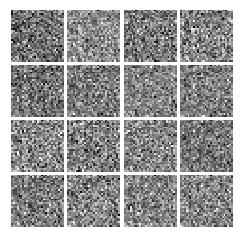


Iter: 0, D: 0.1327, G:0.4029
Iter: 50, D: 0.2576, G:0.7372
Iter: 100, D: 0.02044, G:0.6791
Iter: 150, D: 0.3334, G:1.175
Iter: 200, D: 0.2741, G:0.7671


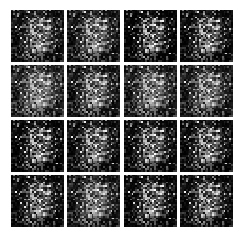


Iter: 250, D: 0.1534, G:0.5075
Iter: 300, D: 0.2289, G:0.4778
Iter: 350, D: 0.0716, G:0.4937
Iter: 400, D: 0.1502, G:0.3743
Iter: 450, D: 0.1311, G:0.2864


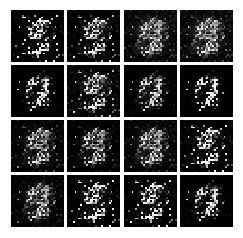


Iter: 500, D: 0.1424, G:0.2769
Iter: 550, D: 0.1106, G:1.011
Iter: 600, D: 0.07892, G:0.4793
Iter: 650, D: 0.1865, G:0.3841
Iter: 700, D: 0.1215, G:0.3268


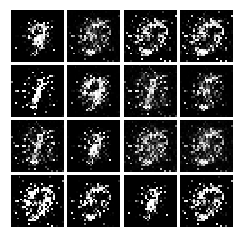


Iter: 750, D: 0.1247, G:0.3084
Iter: 800, D: 0.09892, G:0.4249
Iter: 850, D: 0.1232, G:0.4556
Iter: 900, D: 0.1324, G:0.3065
Iter: 950, D: 0.1746, G:0.2087


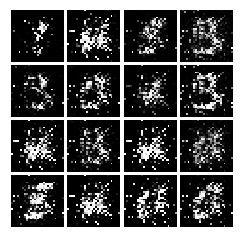


Iter: 1000, D: 0.163, G:0.1655
Iter: 1050, D: 0.1336, G:0.3396
Iter: 1100, D: 0.1543, G:0.7192
Iter: 1150, D: 0.1642, G:0.4416
Iter: 1200, D: 0.264, G:0.2565


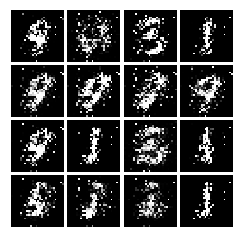


Iter: 1250, D: 0.1395, G:0.4581
Iter: 1300, D: 0.1757, G:0.3606
Iter: 1350, D: 0.1586, G:0.2521
Iter: 1400, D: 0.1686, G:0.227
Iter: 1450, D: 0.1945, G:0.1622


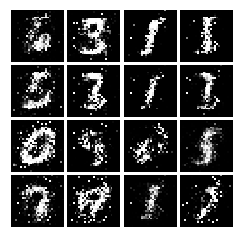


Iter: 1500, D: 0.184, G:0.2135
Iter: 1550, D: 0.1978, G:0.2536
Iter: 1600, D: 0.2176, G:0.23
Iter: 1650, D: 0.212, G:0.2169
Iter: 1700, D: 0.2085, G:0.1829


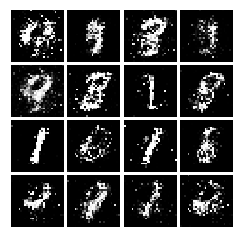


Iter: 1750, D: 0.2126, G:0.2081
Iter: 1800, D: 0.2029, G:0.2015
Iter: 1850, D: 0.1977, G:0.1933
Iter: 1900, D: 0.228, G:0.2142
Iter: 1950, D: 0.2067, G:0.1899


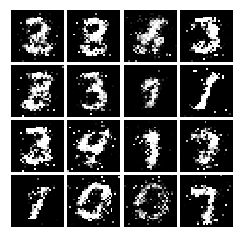


Iter: 2000, D: 0.2088, G:0.1993
Iter: 2050, D: 0.2439, G:0.1849
Iter: 2100, D: 0.2185, G:0.2009
Iter: 2150, D: 0.2195, G:0.2312
Iter: 2200, D: 0.2078, G:0.2001


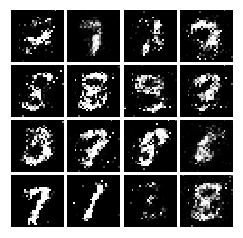


Iter: 2250, D: 0.2178, G:0.1869
Iter: 2300, D: 0.2343, G:0.266
Iter: 2350, D: 0.2143, G:0.1835
Iter: 2400, D: 0.2169, G:0.1763
Iter: 2450, D: 0.2172, G:0.1674


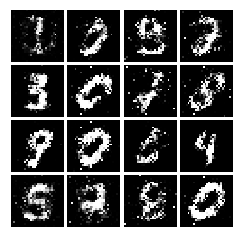


Iter: 2500, D: 0.2161, G:0.1883
Iter: 2550, D: 0.2336, G:0.1565
Iter: 2600, D: 0.2187, G:0.1808
Iter: 2650, D: 0.2096, G:0.1775
Iter: 2700, D: 0.2069, G:0.2059


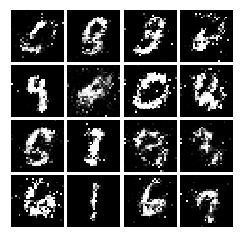


Iter: 2750, D: 0.2227, G:0.1664
Iter: 2800, D: 0.2047, G:0.2144
Iter: 2850, D: 0.2112, G:0.1706
Iter: 2900, D: 0.2132, G:0.2165
Iter: 2950, D: 0.2309, G:0.2532


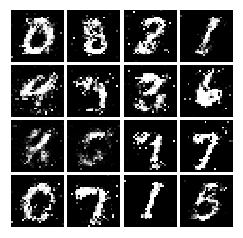


Iter: 3000, D: 0.2223, G:0.2077
Iter: 3050, D: 0.2035, G:0.1682
Iter: 3100, D: 0.2185, G:0.1913
Iter: 3150, D: 0.2076, G:0.2008
Iter: 3200, D: 0.223, G:0.1887


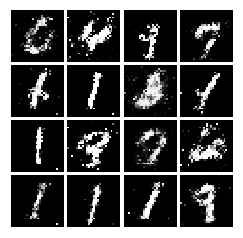


Iter: 3250, D: 0.2092, G:0.165
Iter: 3300, D: 0.2733, G:0.1431
Iter: 3350, D: 0.2177, G:0.2163
Iter: 3400, D: 0.2116, G:0.1726
Iter: 3450, D: 0.2255, G:0.1754


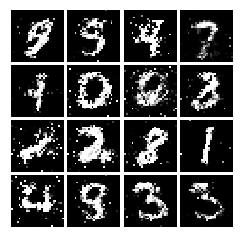


Iter: 3500, D: 0.2148, G:0.1726
Iter: 3550, D: 0.2061, G:0.1708
Iter: 3600, D: 0.219, G:0.1845
Iter: 3650, D: 0.2103, G:0.1619
Iter: 3700, D: 0.2246, G:0.1827


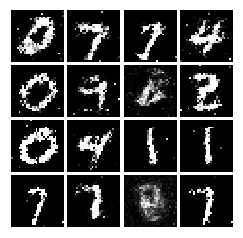


Iter: 3750, D: 0.2119, G:0.1929
Iter: 3800, D: 0.2135, G:0.1631
Iter: 3850, D: 0.2198, G:0.1941
Iter: 3900, D: 0.2257, G:0.1655
Iter: 3950, D: 0.228, G:0.1661


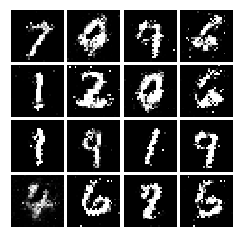


Iter: 4000, D: 0.2276, G:0.1976
Iter: 4050, D: 0.2279, G:0.2023
Iter: 4100, D: 0.2261, G:0.1561
Iter: 4150, D: 0.2347, G:0.1671
Iter: 4200, D: 0.2193, G:0.1928


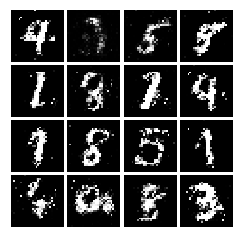


Iter: 4250, D: 0.2213, G:0.1962
Final images


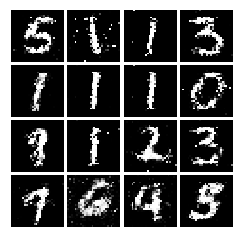

In [26]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

At the start, they're all random noise. As the iterations progress, the images start to differ from each other, and at the end they are recognisable digits.

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [28]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        input_layer = tf.reshape(x, [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],strides =(1,1),activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],strides =(1,1),activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        flatten = tf.reshape(pool2,[-1,1024])
        fc1 = tf.layers.dense(inputs=flatten, units=1024, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc1, units=1)
        
        
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [33]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        layer1 = tf.layers.dense(z,1024,tf.nn.relu)
        batchn1 = tf.layers.batch_normalization(layer1,training = True)
        layer2 = tf.layers.dense(batchn1,7*7*128,tf.nn.relu)
        batchn2 = tf.layers.batch_normalization(layer2,training = True)
        img_tensor = tf.reshape(batchn2,[-1,7,7,128])
        tlayer1 = tf.layers.conv2d_transpose(img_tensor,filters=64,kernel_size=[4,4],strides=(2,2),padding='same',activation=tf.nn.relu)
        batchn3 = tf.layers.batch_normalization(tlayer1,training = True)
        tlayer2 = tf.layers.conv2d_transpose(batchn3,filters=1,kernel_size=[4,4],strides=(2,2),padding='same',activation=tf.tanh)
        img = tf.reshape(tlayer2,[-1,784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [34]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

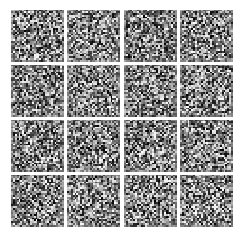


Iter: 0, D: 1.417, G:1.141
Iter: 50, D: 1.323, G:0.8286
Iter: 100, D: 0.7208, G:1.21
Iter: 150, D: 0.905, G:0.3129
Iter: 200, D: 0.9122, G:1.518


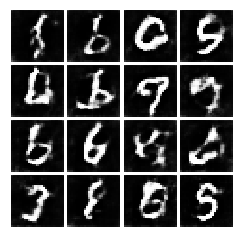


Iter: 250, D: 0.9672, G:1.108
Iter: 300, D: 0.9739, G:1.195
Iter: 350, D: 1.022, G:0.6289
Iter: 400, D: 1.04, G:1.404
Iter: 450, D: 1.062, G:1.158


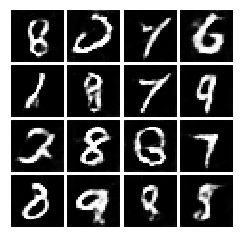


Iter: 500, D: 1.101, G:0.6954
Iter: 550, D: 1.151, G:2.143
Iter: 600, D: 1.174, G:0.7254
Iter: 650, D: 1.094, G:0.9924
Iter: 700, D: 1.158, G:1.128


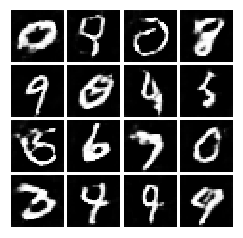


Iter: 750, D: 1.093, G:0.8554
Iter: 800, D: 1.186, G:0.8204
Iter: 850, D: 1.185, G:0.8413
Iter: 900, D: 1.089, G:1.039
Iter: 950, D: 1.226, G:1.635


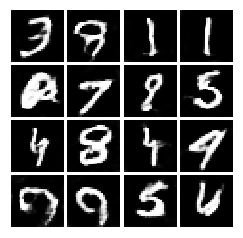


Iter: 1000, D: 1.146, G:1.124
Iter: 1050, D: 1.137, G:1.167
Iter: 1100, D: 1.079, G:1.06
Iter: 1150, D: 1.085, G:1.066
Iter: 1200, D: 1.158, G:1.102


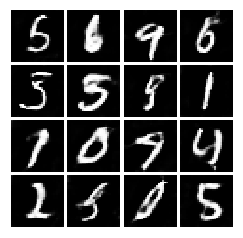


Iter: 1250, D: 1.129, G:1.069
Iter: 1300, D: 1.146, G:0.7102
Iter: 1350, D: 1.085, G:1.156
Iter: 1400, D: 1.086, G:1.252
Iter: 1450, D: 1.089, G:0.9925


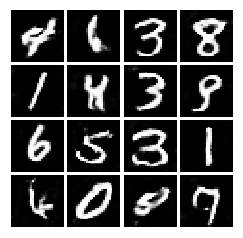


Iter: 1500, D: 1.109, G:0.8723
Iter: 1550, D: 1.037, G:1.055
Iter: 1600, D: 1.112, G:0.8902
Iter: 1650, D: 1.169, G:1.083
Iter: 1700, D: 1.16, G:0.8098


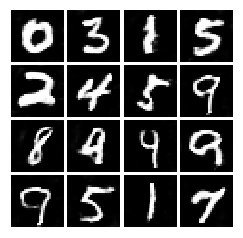


Iter: 1750, D: 1.108, G:0.8647
Iter: 1800, D: 1.084, G:0.7882
Iter: 1850, D: 1.173, G:1.572
Iter: 1900, D: 1.072, G:1.26
Iter: 1950, D: 1.088, G:1.073


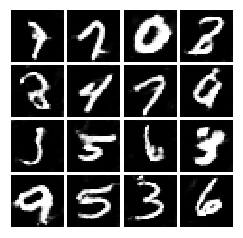


Iter: 2000, D: 1.078, G:1.374
Iter: 2050, D: 1.165, G:0.8731
Iter: 2100, D: 1.066, G:0.6588
Final images


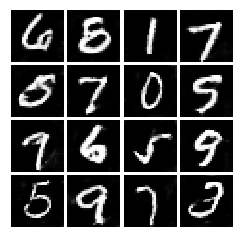

In [35]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

DCGAN is evidently better than the original GAN, owing to using CNNs. This produces sharper images and are better at imitating MNIST

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [40]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        input_layer = tf.reshape(x, [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(inputs=input_layer,filters=64,kernel_size=[4,4],strides =(2,2),activation=leaky_relu)
        conv2 = tf.layers.conv2d(inputs=conv1,filters=128,kernel_size=[4,4],strides =(2,2),activation=leaky_relu)
        batchn1 = tf.layers.batch_normalization(conv2,training = False)
        flatten = tf.reshape(batchn1,[-1,3200])
        fc1 = tf.layers.dense(inputs=flatten, units=1024, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc1, units=1)
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [41]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [43]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    D_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = 0
    x_hat = 0
    eps = tf.random_uniform([batch_size,1], 0,1)
    x_hat = eps*x+(1-eps)*G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = None
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = None
    grad_pen = None
    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))
    D_loss += lam*grad_pen



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

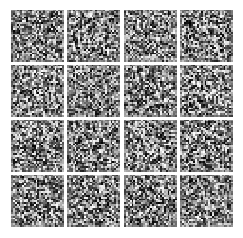


Iter: 0, D: 8.266, G:-0.324
Iter: 50, D: -5.44, G:-11.86
Iter: 100, D: -1.281, G:-12.4
Iter: 150, D: -1.119, G:-13.49
Iter: 200, D: -0.2502, G:-2.667


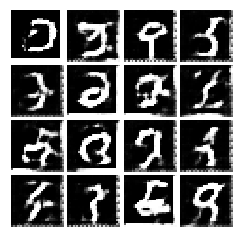


Iter: 250, D: -0.1351, G:-1.595
Iter: 300, D: 0.1769, G:-2.97
Iter: 350, D: -0.8235, G:-9.855
Iter: 400, D: -0.7229, G:-2.909
Iter: 450, D: -0.2652, G:-0.9902


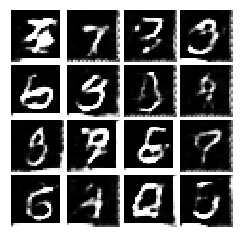


Iter: 500, D: 0.2843, G:-4.577
Iter: 550, D: -0.4149, G:-13.07
Iter: 600, D: -1.192, G:-0.4252
Iter: 650, D: -0.7369, G:-5.736
Iter: 700, D: -0.9915, G:-19.58


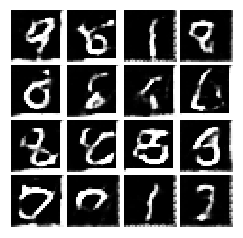


Iter: 750, D: -0.3892, G:3.773
Iter: 800, D: -1.152, G:-7.198
Iter: 850, D: -1.16, G:-10.05
Iter: 900, D: -0.6699, G:2.465
Iter: 950, D: -0.1938, G:-2.738


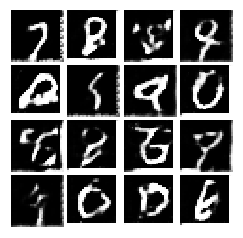


Iter: 1000, D: 0.3957, G:-10.01
Iter: 1050, D: -0.1648, G:-0.1638
Iter: 1100, D: -0.663, G:4.04
Iter: 1150, D: -0.3952, G:-3.093
Iter: 1200, D: -0.8516, G:-13.84


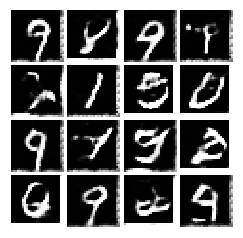


Iter: 1250, D: 0.6513, G:-5.587
Iter: 1300, D: 0.1246, G:-9.716
Iter: 1350, D: 0.3831, G:-3.56
Iter: 1400, D: -0.6493, G:-4.562
Iter: 1450, D: -0.9581, G:-7.063


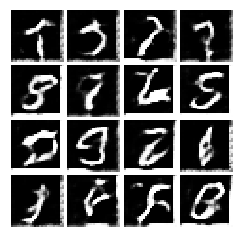


Iter: 1500, D: -0.6948, G:0.6708
Iter: 1550, D: 0.15, G:-5.133
Iter: 1600, D: -0.5794, G:2.4
Iter: 1650, D: -0.2496, G:-5.897
Iter: 1700, D: -0.2376, G:-3.616


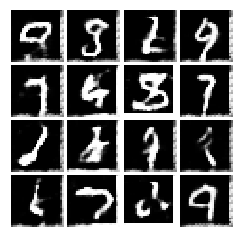


Iter: 1750, D: -0.7949, G:-4.521
Iter: 1800, D: -0.5816, G:-5.888
Iter: 1850, D: -0.266, G:-0.2202
Iter: 1900, D: 0.04297, G:-1.172
Iter: 1950, D: -0.5923, G:-6.394


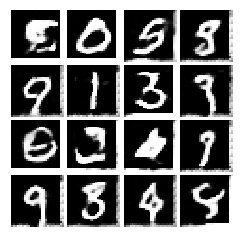


Iter: 2000, D: -0.8323, G:-8.386
Iter: 2050, D: -0.2189, G:-17.42
Iter: 2100, D: -0.7289, G:-6.222
Final images


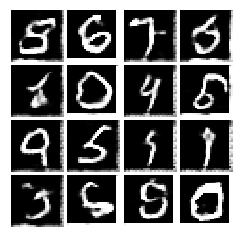

In [44]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)